In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mne
from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test

from os import listdir

In [3]:
def crop_to_RT_and_split(epochs):
    tmin = -0.25
    tmax = 0.8

    epochs = epochs.crop(tmin, tmax)
    picks = mne.pick_types(epochs[0].info, eeg=True, exclude=['Status', 'eog_h', 'eog_v'])

    # Split up the data by metadata
    long_soa = epochs['condition == "long"']
    short_soa = epochs['condition == "short"']

    long_soa.get_data(copy=False, picks=picks).transpose(0, 2, 1)
    short_soa.get_data(copy=False, picks=picks).transpose(0, 2, 1)

    long_soa_data, short_soa_data = long_soa, short_soa

    return long_soa_data, short_soa_data

In [ ]:
def crop_epochs_to_event(event, epochs, task, condition, participant):
    onsets = pd.read_csv('event_data/event_onset_'+condition+'_'+task+'.csv')
    onsets = onsets.loc[(onsets['event'] == event) & (onsets['participant'] == participant)] # Get onsets of current event
    sfreq = epochs[0].info['sfreq']

    cropped_epochs = []
    epochs_data = epochs.get_data()

    for index, row in onsets.iterrows():
        onset = int(row['onset']) / 1000
        trial = row['trial']

        if onset < -0.02:
            continue

        if onset >= 0.8 or onset+0.04 >= 0.8:
            continue

        epoch_idx = epochs.metadata.query("trial_index == @trial").index

        if len(epoch_idx.tolist()) == 0:
            continue
        epoch_idx = np.flatnonzero(np.isin(epochs.selection, epoch_idx))[0]
        
        tmin_idx = int((onset - epochs.times[0]) * sfreq)
        tmax_idx = int((onset+0.04 - epochs.times[0]) * sfreq)
        cropped_epochs.append(epochs_data[epoch_idx, :, tmin_idx:tmax_idx])
  
    # Truncate all epochs to this minimum length
    min_samples = min(epoch.shape[1] for epoch in cropped_epochs)
    cropped_epochs = [epoch[:, :min_samples] for epoch in cropped_epochs]

    # Convert list of cropped epochs into a NumPy array and recreate EpochsArray
    return mne.EpochsArray(np.array(cropped_epochs, dtype=np.float32), epochs.info)

In [ ]:
def crop_epochs_to_central_processing(epochs, task, condition, participant):
    onsets = pd.read_csv('event_data/event_onset_'+condition+'_'+task+'.csv')
    onsets = onsets.loc[(onsets['event'] == 2) & (onsets['participant'] == participant)] # Get onsets of event 2
    sfreq = epochs[0].info['sfreq']

    cropped_epochs = []
    epochs_data = epochs.get_data()

    for index, row in onsets.iterrows():
        onset = int(row['onset']) / 1000
        trial = row['trial']

        if onset < 0:
            continue

        if onset >= 0.8 or onset+0.275 >= 0.8:
            continue

        epoch_idx = epochs.metadata.query("trial_index == @trial").index

        if len(epoch_idx.tolist()) == 0:
            continue
        epoch_idx = np.flatnonzero(np.isin(epochs.selection, epoch_idx))[0]
        
        tmin_idx = int((onset - epochs.times[0]) * sfreq)
        tmax_idx = int((onset+0.275 - epochs.times[0]) * sfreq) #275 ms T1 / 295 ms T2

        if tmin_idx > tmax_idx:
            continue
        
        cropped_epochs.append(epochs_data[epoch_idx, :, tmin_idx:tmax_idx])
 
    # Truncate all epochs to this minimum length
    min_samples = min(epoch.shape[1] for epoch in cropped_epochs)
    cropped_epochs = [epoch[:, :min_samples] for epoch in cropped_epochs]

    # Convert list of cropped epochs into a NumPy array and recreate EpochsArray
    return mne.EpochsArray(np.array(cropped_epochs, dtype=np.float32), epochs.info)

In [ ]:
def calculate_significant_points(long_epochs, short_epochs):
    picks = mne.pick_types(long_epochs[0].info, eeg=True, exclude=['Status', 'eog_h', 'eog_v'])

    long_epochs.info.set_montage(long_epochs.info.get_montage())
    short_epochs.info.set_montage(short_epochs.info.get_montage())

    X = [
        long_epochs.get_data(copy=False, picks=picks).transpose(0, 2, 1),
        short_epochs.get_data(copy=False, picks=picks).transpose(0, 2, 1),
    ]
    tfce = dict(start=0.4, step=0.4)
    adjacency, _ = find_ch_adjacency(long_epochs.info, "eeg")

    # Calculate statistical thresholds
    t_obs, clusters, cluster_pv, h0 = spatio_temporal_cluster_test(X, tfce, adjacency=adjacency, n_permutations=100)
    significant_points = cluster_pv.reshape(t_obs.shape).T < 0.05
    print(str(significant_points.sum()) + " points selected by TFCE ...")

    return significant_points

In [ ]:
def plot_results(cropped_epochs_long, cropped_epochs_short, significant_points):
    # Get difference
    evoked = mne.combine_evoked([cropped_epochs_long.average(), cropped_epochs_short.average()], weights=[1, -1])
    time_unit = dict(time_unit="s")
    evoked.plot_joint(times=[0.01, 0.02, 0.03], title="Long vs. short SOA", ts_args=time_unit, topomap_args=time_unit)

    # Create ROIs by checking channel labels
    selections = make_1020_channel_selections(evoked.info, midline="12z")

    # Visualize the results
    fig, axes = plt.subplots(nrows=3, figsize=(8, 8))
    axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
    evoked.plot_image(
        axes=axes,
        group_by=selections,
        colorbar=False,
        show=False,
        mask=significant_points,
        show_names="all",
        titles=None,
        **time_unit,
    )
    
    plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=0.3, label="µV")
    plt.show()

Participant VP10_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
301 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
282 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  301 events (all good), 0 – 0.197266 s, baseline off, ~15.8 MB, data loaded,
 '1': 301> <EpochsArray |  282 events (all good), 0 – 0.197266 s, baseline off, ~14.8 MB, data loaded,
 '1': 282>
Participant VP11_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
272 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  261 events (all good), 0 – 0.197266 s, baseline off, ~13.7 MB, data loaded,
 '1': 261> <EpochsArray |  272 events (all good), 0 – 0.197266 s, baseline off, ~14.3 MB, data loaded,
 '1': 272>
Participant VP12_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
221 matching events found
No baseline correction applied
0 projection items activated
Truncating
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Amount of epochs (long / short) <EpochsArray |  221 events (all good), 0 – 0.197266 s, baseline off, ~11.6 MB, data loaded,
 '1': 221> <EpochsArray |  125 events (all good), 0 – 0.197266 s, baseline off, ~6.6 MB, data loaded,
 '1': 125>
Participant VP13_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  261 events (all good), 0 – 0.197266 s, baseline off, ~13.7 MB, data loaded,
 '1': 261> <EpochsArray |  232 events (all good), 0 – 0.197266 s, baseline off, ~12.2 MB, data loaded,
 '1': 232>
Participant VP14_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  279 events (all good), 0 – 0.197266 s, baseline off, ~14.6 MB, data loaded,
 '1': 279> <EpochsArray |  336 events (all good), 0 – 0.197266 s, baseline off, ~17.6 MB, data loaded,
 '1': 336>
Participant VP15_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
330 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
266 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  330 events (all good), 0 – 0.197266 s, baseline off, ~17.3 MB, data loaded,
 '1': 330> <EpochsArray |  266 events (all good), 0 – 0.197266 s, baseline off, ~13.9 MB, data loaded,
 '1': 266>
Participant VP16_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
330 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  330 events (all good), 0 – 0.197266 s, baseline off, ~17.3 MB, data loaded,
 '1': 330> <EpochsArray |  294 events (all good), 0 – 0.197266 s, baseline off, ~15.4 MB, data loaded,
 '1': 294>
Participant VP17_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  138 events (all good), 0 – 0.197266 s, baseline off, ~7.3 MB, data loaded,
 '1': 138> <EpochsArray |  160 events (all good), 0 – 0.197266 s, baseline off, ~8.4 MB, data loaded,
 '1': 160>
Participant VP18_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
273 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  273 events (all good), 0 – 0.197266 s, baseline off, ~14.3 MB, data loaded,
 '1': 273> <EpochsArray |  268 events (all good), 0 – 0.197266 s, baseline off, ~14.1 MB, data loaded,
 '1': 268>
Participant VP19_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
330 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  330 events (all good), 0 – 0.197266 s, baseline off, ~17.3 MB, data loaded,
 '1': 330> <EpochsArray |  318 events (all good), 0 – 0.197266 s, baseline off, ~16.7 MB, data loaded,
 '1': 318>
Participant VP1_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  184 events (all good), 0 – 0.197266 s, baseline off, ~9.7 MB, data loaded,
 '1': 184> <EpochsArray |  119 events (all good), 0 – 0.197266 s, baseline off, ~6.3 MB, data loaded,
 '1': 119>
Participant VP20_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
246 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  246 events (all good), 0 – 0.197266 s, baseline off, ~12.9 MB, data loaded,
 '1': 246> <EpochsArray |  254 events (all good), 0 – 0.197266 s, baseline off, ~13.3 MB, data loaded,
 '1': 254>
Participant VP21_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
231 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  231 events (all good), 0 – 0.197266 s, baseline off, ~12.1 MB, data loaded,
 '1': 231> <EpochsArray |  306 events (all good), 0 – 0.197266 s, baseline off, ~16.0 MB, data loaded,
 '1': 306>
Participant VP22_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
326 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
305 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  326 events (all good), 0 – 0.197266 s, baseline off, ~17.1 MB, data loaded,
 '1': 326> <EpochsArray |  305 events (all good), 0 – 0.197266 s, baseline off, ~16.0 MB, data loaded,
 '1': 305>
Participant VP23_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
247 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  288 events (all good), 0 – 0.197266 s, baseline off, ~15.1 MB, data loaded,
 '1': 288> <EpochsArray |  247 events (all good), 0 – 0.197266 s, baseline off, ~13.0 MB, data loaded,
 '1': 247>
Participant VP24_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
301 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  301 events (all good), 0 – 0.197266 s, baseline off, ~15.8 MB, data loaded,
 '1': 301> <EpochsArray |  281 events (all good), 0 – 0.197266 s, baseline off, ~14.7 MB, data loaded,
 '1': 281>
Participant VP2_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  268 events (all good), 0 – 0.197266 s, baseline off, ~14.1 MB, data loaded,
 '1': 268> <EpochsArray |  256 events (all good), 0 – 0.197266 s, baseline off, ~13.4 MB, data loaded,
 '1': 256>
Participant VP3_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
284 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  284 events (all good), 0 – 0.197266 s, baseline off, ~14.9 MB, data loaded,
 '1': 284> <EpochsArray |  311 events (all good), 0 – 0.197266 s, baseline off, ~16.3 MB, data loaded,
 '1': 311>
Participant VP5_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
276 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
263 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  276 events (all good), 0 – 0.197266 s, baseline off, ~14.5 MB, data loaded,
 '1': 276> <EpochsArray |  263 events (all good), 0 – 0.197266 s, baseline off, ~13.8 MB, data loaded,
 '1': 263>
Participant VP8_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
175 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  175 events (all good), 0 – 0.197266 s, baseline off, ~9.2 MB, data loaded,
 '1': 175> <EpochsArray |  180 events (all good), 0 – 0.197266 s, baseline off, ~9.5 MB, data loaded,
 '1': 180>
Participant VP9_epo_t2_2.fif


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
284 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\3209991062.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


Truncating
Not setting metadata
222 matching events found
No baseline correction applied
0 projection items activated
Amount of epochs (long / short) <EpochsArray |  284 events (all good), 0 – 0.197266 s, baseline off, ~14.9 MB, data loaded,
 '1': 284> <EpochsArray |  222 events (all good), 0 – 0.197266 s, baseline off, ~11.7 MB, data loaded,
 '1': 222>
Not setting metadata
301 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
221 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
330 matching events found
No baseline correction applied
0 projection items activated
No

C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:27: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  min_samples = min(min(epoch.get_data().shape[2] for epoch in long_epochs), min(epoch.get_data().shape[2] for epoch in short_epochs))
C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:27: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  min_samples = min(min(epoch.get_data().shape[2] for epoch in long_epochs), min(epoch.get_data().shape[2] for epoch in short_epochs))
C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:27: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  min_samples = min(min(epoch.get_data().shape[2] for epoch in long_epochs), min(epoch.get_data().shape[2] for epoc

Not setting metadata
273 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
330 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
246 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
231 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
326 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
301 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
284 matching eve

C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:28: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  long_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.info) for epoch in long_epochs]
C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:28: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  long_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.info) for epoch in long_epochs]
C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:28: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  long_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.inf

No baseline correction applied
0 projection items activated
Not setting metadata
175 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
284 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
282 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
272 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
266 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:28: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  long_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.info) for epoch in long_epochs]
C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:28: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  long_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.info) for epoch in long_epochs]
C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:29: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  short_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.in

294 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
305 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
247 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
281 matching events found
No baseline

C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:29: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  short_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.info) for epoch in short_epochs]
C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:29: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  short_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.info) for epoch in short_epochs]
C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:29: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  short_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epoch

311 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
263 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
222 matching events found
No baseline correction applied
0 projection items activated


C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:29: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  short_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.info) for epoch in short_epochs]
C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:29: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  short_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.info) for epoch in short_epochs]
C:\Users\annad\AppData\Local\Temp\ipykernel_14320\1301632229.py:29: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  short_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epoch

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64
Start test
stat_fun(H1): min=4.313107992096776e-07 max=97.00918254861594
Running initial clustering …
Using 242 thresholds from 0.40 to 96.80 for TFCE computation (h_power=2.00, e_power=0.50)
Found 6528 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

4041 points selected by TFCE ...
No projector specified for this dataset. Please consider the method self.add_proj.


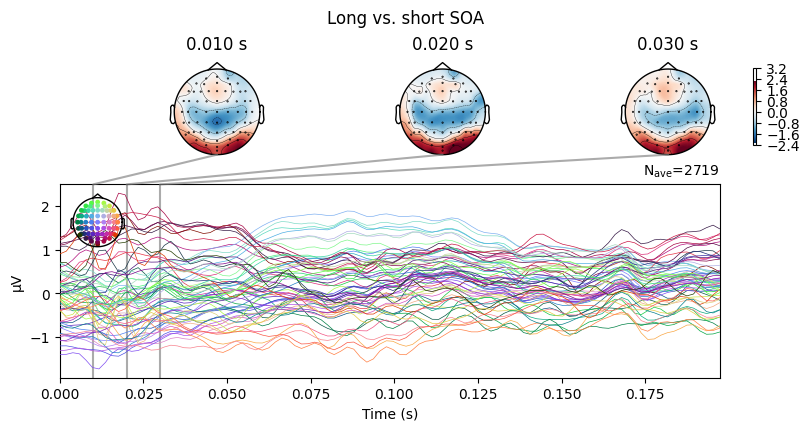

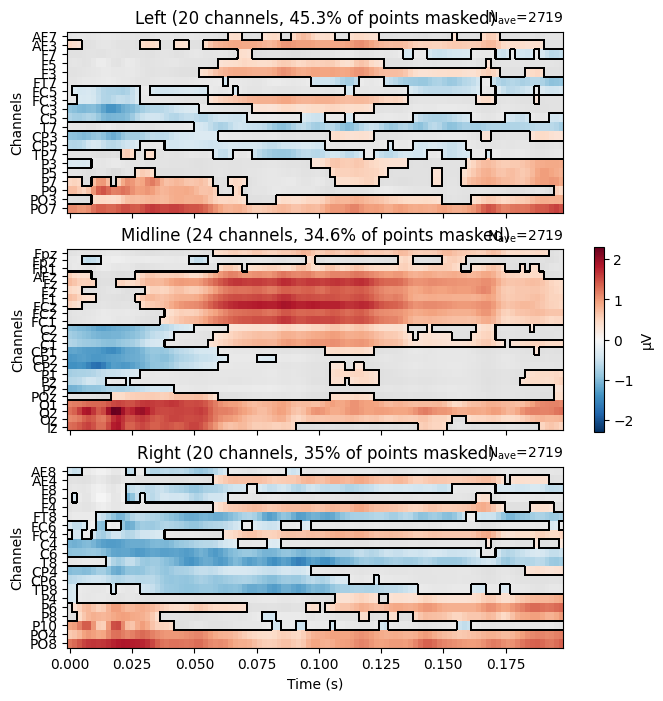

In [ ]:
path = 'C:/Users/annad/Documents/Thesis/Data/Stimlocked_fixed_index/'
task = 't1'

for event in [1, 2, 3, 4]:
    long_epochs = []
    short_epochs = []

    for x in listdir(path):
        if '_'+task+'.fif' in x:
            print("Participant", x)
            epochs = mne.read_epochs(path+x, verbose="critical")
            participant = x.split(".")[0]

            long_soa_data, short_soa_data = crop_to_RT_and_split(epochs)

            long_epochs_cropped = crop_epochs_to_event(event, long_soa_data, task, 'long', participant)
            short_epochs_cropped = crop_epochs_to_event(event, short_soa_data, task, 'short', participant)
            # long_epochs_cropped = crop_epochs_to_central_processing(long_soa_data, task, 'long', participant)
            # short_epochs_cropped = crop_epochs_to_central_processing(short_soa_data, task, 'short', participant)

            long_epochs.append(long_epochs_cropped)
            short_epochs.append(short_epochs_cropped)
    
    # Only necessary for central processing stage. To make sure all epochs are of same length
    # min_samples = min(min(epoch.get_data().shape[2] for epoch in long_epochs), min(epoch.get_data().shape[2] for epoch in short_epochs))
    # long_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.info) for epoch in long_epochs]
    # short_epochs = [mne.EpochsArray(np.array(epoch.get_data()[:, :, :min_samples], dtype=np.float32), epochs.info) for epoch in short_epochs]

    long_epochs = mne.concatenate_epochs(long_epochs, verbose="critical")
    short_epochs = mne.concatenate_epochs(short_epochs, verbose="critical")

    long_epochs.save(f"epochs_long_{task}_e{event}.fif", overwrite=True)
    short_epochs.save(f"epochs_short_{task}_e{event}.fif", overwrite=True)
    
    # long_epochs.save(f"epochs_long_{task}_centrproc.fif", overwrite=True)
    # short_epochs.save(f"epochs_short_{task}_centrproc.fif", overwrite=True)

    sign_points = calculate_significant_points(long_epochs, short_epochs)
    plot_results(long_epochs, short_epochs, sign_points)